# Equipe

- Danilho Scheltes
- Felipe Lima
- Guilherme Martinho
- Rafael Santos
- Rodrigo Macedo

# Problema

- O problema consiste em otimizar a aplicação do filtro laplaciano em matrizes quadradas.

- Este filtro é particularmente útil para detecção de bordas em imagens.

- Considerando uma imagem como uma matriz $M$, sua filtragem consiste em realizar uma operação de convolução entre $M$ e uma matriz de pesos $K$, denominada kernel.

- Em outras palavras, a matriz da imagem filtrada $F$ é definida como $F=M*K$.

- Para o caso do filtro laplaciano, pode-se utilizar a seguinte matriz como kernel:

- $K=\begin{bmatrix}
  \phantom{-}0 & -1 & \phantom{-}0 \\
  -1 & \phantom{-}4 & -1 \\
  \phantom{-}0 & -1 & \phantom{-}0
 \end{bmatrix}$

# Validação dos códigos

- Para problemas de tamanho menor ou igual a 1024, todos os códigos irão gerar como saída um arquivo `.txt` contendo a matriz filtrada.

- A saída do código sequencial será sempre considerada como correta.

- Todas as outras soluções serão consideradas válidas caso suas saídas sejam iguais à da versão sequencial.

- Segue abaixo o script que compara duas saídas:

In [ ]:
%%writefile compare_files.sh

#!/bin/bash

if [ ! -e "$1" ]; then
    echo "Erro: $1 não foi encontrado."
    exit 1
fi
if [ ! -e "$2" ]; then
    echo "Erro: $2 não foi encontrado."
    exit 1
fi

resultado_diff=$(diff "$1" "$2")

if [ -z "$resultado_diff" ]; then
    echo "O conteúdo dos arquivos é igual"
else
    echo "O conteúdo dos arquivos é diferente"
fi

Overwriting compare_files.sh


In [ ]:
!chmod +x compare_files.sh

# Sequencial

In [ ]:
%%writefile laplacian_seq.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

typedef double matrix_type;
typedef matrix_type *matrix;

void fill_matrix(matrix m, int N)
{
    int i, j;
    for (i = 0; i < N; i++)
        for (j = 0; j < N; j++)
            m[i * N + j] = (i + j + 2) * 1.;
    ;
}

void apply_filter(matrix m, matrix m_fil, int N)
{
    double delta_x, delta_y;
    int i, j;
    for (i = 1; i < (N - 1); i++)
        for (j = 1; j < (N - 1); j++)
        {
            delta_x = 2 * m[i * N + j] + m[i * N + (j - 1)] + m[i * N + (j + 1)];
            delta_y = 2 * m[i * N + j] + m[(i - 1) * N + j] + m[(i + 1) * N + j];
            m_fil[i * N + j] = delta_x + delta_y;
        }
}

void write_filtered_matrix(matrix m_fil, int N)
{
    if (N > 1024)
    {
        printf("Tamanho de matriz muito grande para salvar em arquivo\n\n");
        return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_seq_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    int i, j;
    for (i = 0; i < N; i++)
    {
        for (j = 0; j < N; j++)
            fprintf(f_out, "%lf ", m_fil[i * N + j]);
        fprintf(f_out, "\n");
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n\n", file_name);
}

int main(int argc, char *argv[])
{
    int N = atoi(argv[1]);
    matrix m, m_fil;
    double t;

    t = omp_get_wtime();

    m = (matrix)calloc(N * N, sizeof(matrix_type));
    m_fil = (matrix)calloc(N * N, sizeof(matrix_type));
    if (m == NULL || m_fil == NULL)
    {
        printf("Failed to allocate matrix of size %d x %d\n", N, N);
        return 1;
    }

    fill_matrix(m, N);

    apply_filter(m, m_fil, N);

    t = omp_get_wtime() - t;
    printf("%d x %d: %lf\n", N, N, t);

    write_filtered_matrix(m_fil, N);

    free(m);
    free(m_fil);

    return 0;
}


Writing laplacian_seq.c


# OpenMP

In [ ]:
%%writefile laplacian_omp.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

typedef double matrix_type;
typedef matrix_type *matrix;

void fill_matrix(matrix m, int N)
{
    int i, j;
    #pragma omp for collapse(2)
    for (i = 0; i < N; i++)
        for (j = 0; j < N; j++)
            m[i * N + j] = (i + j + 2) * 1.;
}

void apply_filter(matrix m, matrix m_fil, int N)
{
    int i, j;
    #pragma omp for collapse(2)
    for (i = 1; i < (N - 1); i++)
        for (j = 1; j < (N - 1); j++)
        {
            double delta_x, delta_y;
            delta_x = 2 * m[i * N + j] + m[i * N + (j - 1)] + m[i * N + (j + 1)];
            delta_y = 2 * m[i * N + j] + m[(i - 1) * N + j] + m[(i + 1) * N + j];
            m_fil[i * N + j] = delta_x + delta_y;
        }
}

void write_filtered_matrix(matrix m_fil, int N)
{
    if (N > 1024)
    {
        printf("Tamanho de matriz muito grande para salvar em arquivo\n");
        return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_omp_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    int i, j;
    for (i = 0; i < N; i++)
    {
        for (j = 0; j < N; j++)
            fprintf(f_out, "%lf ", m_fil[i * N + j]);
        fprintf(f_out, "\n");
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n", file_name);
}

int main(int argc, char *argv[])
{
    int N = atoi(argv[1]);
    matrix m, m_fil;
    double t, t_total = 0;

    printf("%d:\n\t", N);

    m = (matrix)calloc(N * N, sizeof(matrix_type));
    m_fil = (matrix)calloc(N * N, sizeof(matrix_type));
    if (m == NULL || m_fil == NULL)
    {
        printf("Failed to allocate matrix of size %dX%d\n", N, N);
        return 1;
    }

    t = omp_get_wtime();
    fill_matrix(m, N);
    t = omp_get_wtime() - t;
    printf("fill_matrix\t%lf\n\t", t);
    t_total += t;

    t = omp_get_wtime();
    apply_filter(m, m_fil, N);
    t = omp_get_wtime() - t;
    printf("apply_filter\t%lf\n\t", t);
    t_total += t;

    printf("total time\t%lf\n\t", t_total);

    write_filtered_matrix(m_fil, N);

    free(m);
    free(m_fil);

    return 0;
}


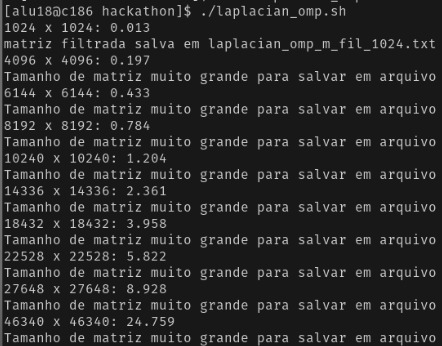

In [ ]:
%%writefile laplacian_omp.sh

gcc laplacian_omp.c -o laplacian_omp -fopenmp

for i in 1024 4096 6144 8192 10240 14336 18432 22528 27648 46340; do
  OMP_NUM_THREADS=64 ./laplacian_omp $i
done

# CUDA

## GPU única

In [ ]:
%%writefile laplacian_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <cuda.h>
#include <cuda_runtime.h>

typedef double matrix_type;
typedef matrix_type *matrix;

#define check_cuda_err(val)               \
    {                                     \
        check((val), __FILE__, __LINE__); \
    }
void check(cudaError_t code, char *file, int line)
{
    if (code != cudaSuccess)
    {
        fprintf(stderr, "GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
        exit(code);
    }
}

__global__ void fill_matrix(matrix m, int N)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = gridDim.x * blockDim.x;

    int stride_i = stride / N;
    int i = idx / N;

    int stride_j = stride % N;
    int j = idx % N;

    while (i < N)
    {
        m[i * N + j] = i + j + 2.;

        i += stride_i;
        j += stride_j;
        if (j >= N)
        {
            i++;
            j -= N;
        }
    }
}

__global__ void apply_filter(matrix m, matrix m_fil, int N)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = gridDim.x * blockDim.x;

    int stride_i = stride / N;
    int i = idx / N;

    int stride_j = stride % N;
    int j = idx % N;

    double delta_x, delta_y;
    while (i < N)
    {
        if (i == 0 || j == 0 || i == N - 1 || j == N - 1)
            m_fil[i * N + j] = 0;
        else
        {
            delta_x = 2 * m[i * N + j] + m[i * N + (j - 1)] + m[i * N + (j + 1)];
            delta_y = 2 * m[i * N + j] + m[(i - 1) * N + j] + m[(i + 1) * N + j];
            m_fil[i * N + j] = delta_x + delta_y;
        }

        i += stride_i;
        j += stride_j;
        if (j >= N)
        {
            i++;
            j -= N;
        }
    }
}

void write_filtered_matrix(matrix m_fil, int N)
{
    if (N > 1024)
    {
        printf("Tamanho de matriz muito grande para salvar em arquivo\n\n");
        return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_cuda_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    for (int i = 0; i < N; i++)
    {
        for (int j = 0; j < N; j++)
            fprintf(f_out, "%lf ", m_fil[i * N + j]);
        fprintf(f_out, "\n");
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n\n", file_name);
}

int main(int argc, char *argv[])
{
    int N = atoi(argv[1]);
    matrix m, m_fil;
    double t;

    int device_id;
    cudaGetDevice(&device_id);
    cudaDeviceProp props;
    cudaGetDeviceProperties(&props, device_id);
    // int num_blocks = props.multiProcessorCount * props.maxBlocksPerMultiProcessor;
    int num_blocks = props.multiProcessorCount * 32;
    int num_threads = min(props.maxThreadsPerMultiProcessor, props.maxThreadsPerBlock);
    check_cuda_err(cudaPeekAtLastError());

    printf("%d x %d: ", N, N);

    t = omp_get_wtime();

    check_cuda_err(cudaMallocManaged(&m, N * N * sizeof(matrix_type)));
    check_cuda_err(cudaMallocManaged(&m_fil, N * N * sizeof(matrix_type)));

    fill_matrix<<<num_blocks, num_threads>>>(m, N);
    check_cuda_err(cudaPeekAtLastError());

    apply_filter<<<num_blocks, num_threads>>>(m, m_fil, N);
    check_cuda_err(cudaPeekAtLastError());
    check_cuda_err(cudaDeviceSynchronize());

    t = omp_get_wtime() - t;
    printf("%.3lf\n", t);

    write_filtered_matrix(m_fil, N);

    cudaFree(m);
    cudaFree(m_fil);

    return 0;
}


Overwriting laplacian_cuda.cu


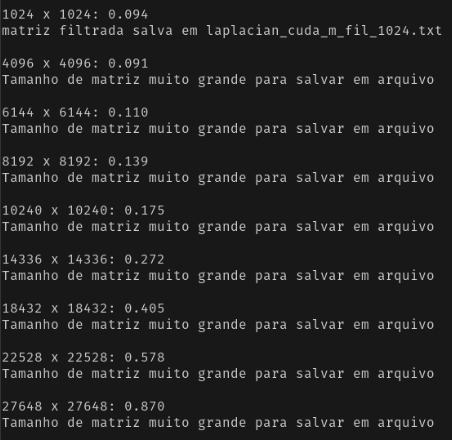

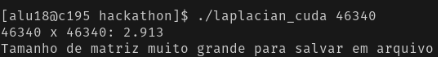

In [ ]:
%%writefile laplacian_cuda.sh

nvcc -Xcompiler -fopenmp laplacian_cuda.cu -o laplacian_cuda

for i in 1024 4096 6144 8192 10240 14336 18432 22528 27648 46340; do
  ./laplacian_cuda $i
done

## MultiGPU

In [ ]:
%%writefile laplacian_cuda_multigpu.cu
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <cuda.h>
#include <cuda_runtime.h>

typedef double matrix_type;
typedef matrix_type *matrix;

#define check_cuda_err(val)               \
    {                                     \
        check((val), __FILE__, __LINE__); \
    }
void check(cudaError_t code, char *file, int line)
{
    if (code != cudaSuccess)
    {
        fprintf(stderr, "GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
        exit(code);
    }
}

__global__ void fill_matrix(matrix m, int N, int gpu_id, int lines_per_gpu)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = gridDim.x * blockDim.x;

    int stride_i = stride / N;
    int i = idx / N;

    int stride_j = stride % N;
    int j = idx % N;

    // With the exception of the last GPU, the 'm' GPU matrices must have the line after the last line of 'm_fil'
    int i_min = gpu_id * lines_per_gpu, i_max = min(N, i_min + lines_per_gpu + 1);
    // With the exception of GPU 0, the 'm' GPU matrices must have the line before the first line of 'm_fil'
    if (gpu_id != 0)
        i_min--;
    while (i < i_max)
    {
        if (i >= i_min)
            m[(i - i_min) * N + j] = i + j + 2.;

        i += stride_i;
        j += stride_j;
        if (j >= N)
        {
            i++;
            j -= N;
        }
    }
}

__global__ void apply_filter(matrix m, matrix m_fil, int N, int gpu_id, int lines_per_gpu)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = gridDim.x * blockDim.x;

    int stride_i = stride / N;
    int i = idx / N;

    int stride_j = stride % N;
    int j = idx % N;

    int i_min = gpu_id * lines_per_gpu, i_max = min(N, i_min + lines_per_gpu), inc;
    double delta_x, delta_y;
    while (i < i_max)
    {
        if (i >= i_min)
        {
            if (i == 0 || j == 0 || i == N - 1 || j == N - 1)
                m_fil[(i - i_min) * N + j] = 0;
            else
            {
                inc = gpu_id != 0;
                delta_x = 2 * m[(i + inc - i_min) * N + j] + m[(i + inc - i_min) * N + (j - 1)] + m[(i + inc - i_min) * N + (j + 1)];
                delta_y = 2 * m[(i + inc - i_min) * N + j] + m[(i + inc - i_min - 1) * N + j] + m[(i + inc - i_min + 1) * N + j];
                m_fil[(i - i_min) * N + j] = delta_x + delta_y;
            }
        }

        i += stride_i;
        j += stride_j;
        if (j >= N)
        {
            i++;
            j -= N;
        }
    }
}

void write_filtered_matrix(matrix m_fil_gpus[], int N, int gpu_count, int lines_per_gpu)
{
    if (N > 1024)
    {
        printf("Tamanho de matriz muito grande para salvar em arquivo\n\n");
        return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_cuda_multigpu_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    for (int k = 0; k < gpu_count; k++)
    {
        int jump = k * lines_per_gpu;
        for (int i = 0; i < lines_per_gpu && i + jump < N; i++)
        {
            for (int j = 0; j < N; j++)
                fprintf(f_out, "%lf ", m_fil_gpus[k][i * N + j]);
            fprintf(f_out, "\n");
        }
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n\n", file_name);
}

void execute_multi_gpu(int N, int gpu_count)
{
    int lines_per_gpu = 1 + (N - 1) / gpu_count;
    matrix m_gpus[gpu_count], m_fil_gpus[gpu_count];
    double t = omp_get_wtime();

// number of threads is equal to gpu_count
// Each CPU thread launchs its GPU kernels
#pragma omp parallel
    {
        int tid = omp_get_thread_num();
        cudaSetDevice(tid);

        check_cuda_err(cudaMallocManaged(&m_gpus[tid], (lines_per_gpu + 2) * N * sizeof(matrix_type)));
        check_cuda_err(cudaMallocManaged(&m_fil_gpus[tid], lines_per_gpu * N * sizeof(matrix_type)));

        // Gets GPU props of this thread
        cudaDeviceProp props;
        check_cuda_err(cudaGetDeviceProperties(&props, tid));
        // int num_blocks = props.multiProcessorCount * props.maxBlocksPerMultiProcessor;
        int num_blocks = props.multiProcessorCount * 32;
        int num_threads = min(props.maxThreadsPerMultiProcessor, props.maxThreadsPerBlock);

        fill_matrix<<<num_blocks, num_threads>>>(m_gpus[tid], N, tid, lines_per_gpu);
        check_cuda_err(cudaPeekAtLastError());

        apply_filter<<<num_blocks, num_threads>>>(m_gpus[tid], m_fil_gpus[tid], N, tid, lines_per_gpu);
        check_cuda_err(cudaPeekAtLastError());
        check_cuda_err(cudaDeviceSynchronize());
    }

    t = omp_get_wtime() - t;
    printf("%d %d: %.3lf\n", N, N, t);

    write_filtered_matrix(m_fil_gpus, N, gpu_count, lines_per_gpu);

    for (int k = 0; k < gpu_count; k++)
    {
        cudaSetDevice(k);

        cudaFree(m_gpus[k]);
        cudaFree(m_fil_gpus[k]);
    }
}

int main(int argc, char *argv[])
{

    int N = atoi(argv[1]);
    int gpu_count = atoi(argv[2]);

    omp_set_num_threads(gpu_count);
    execute_multi_gpu(N, gpu_count);

    return 0;
}


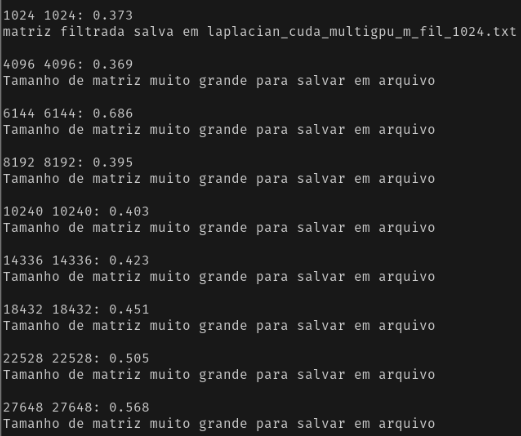

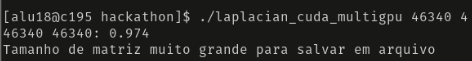

In [ ]:
%%writefile laplacian_cuda_multigpu.sh

nvcc -Xcompiler -fopenmp laplacian_cuda_multigpu.cu -o laplacian_cuda_multigpu

for i in 1024 4096 6144 8192 10240 14336 18432 22528 27648 46340; do
  ./laplacian_cuda_multigpu $i 4
done

### Consumo de Memória

- Considerando como entrada uma matriz quadrada de ordem `N` e que o trabalho será dividido por 4 GPUs, as matrizes `m` e `m_fil` serão de ordem `(N/4+2) x N` e `(N/4) x N`, respectivamente.
- Dessa forma, o consumo de memória de cada GPU será dado por:

\begin{equation}
M =  \left[ \left(\frac{N}{4}+2 \right)\cdot N+\frac{N}{4}\cdot N \right]\cdot \frac{sizeof(double)}{1024^3}
\end{equation}

- Sendo `sizeof(double)=8` e considerando que a memória máxima de cada GPU é `M=32GB`, o maior valor de `N` pode ser calculado resolvendo a seguinte equação:

\begin{equation}
32 =  \left( \frac{N}{2}+2 \right)\cdot N\cdot \frac{8}{1024^3}
\end{equation}

\begin{equation}
N\approx 92670
\end{equation}

- Rodando o código para o tamanho acima, obtivemos o seguinte tempo:

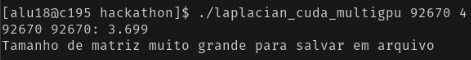

# Análise Experimental

## Parâmetros de Execução

1. OpenMP = 64 Threads
4. CUDA = G1D B1DT1D (`n_mps` * 32, 1024), onde `n_mps` é a quantidade de multiprocessadores da GPU

## Valores menores

### Tempo de execução, em segundos

|  Entrada        | Sequencial | OpenMP | CUDA | CUDA (MultiGPU)
| ----------------| -----------| ------ | ---- | --------------
| 1024 x 1024     |   0.010    |  0.013 | 0.094|     0.373          
| 4096 x 4096     |   0.256    |  0.197 | 0.091|     0.369          
| 6144 x 6144     |   0.610    |  0.433 | 0.110|     0.686          
| 8192 x 8192     |   1.267    |  0.784 | 0.139|     0.395          
| 10240 x 10240   |   1.686    |  1.204 | 0.175|     0.403          
| 14336 x 14336   |   3.385    |  2.361 | 0.272|     0.423          
| 18432 x 18432   |   6.912    |  3.958 | 0.405|     0.451          
| 22528 x 22528   |   8.460    |  5.822 | 0.578|     0.505          
| 27648 x 27648   |   15.100   |  8.928 | 0.870|     0.568          

### Speedups

|  Entrada        | Sequencial | OpenMP | CUDA | CUDA (MultiGPU)
| ----------------| -----------| ------ | ---- | --------------
| 1024 x 1024     |   -        | 0.769 | 0.106|     0.027          
| 4096 x 4096     |   -        | 1.299 | 2.813|     0.694          
| 6144 x 6144     |   -        | 1.409 | 5.545|     0.889          
| 8192 x 8192     |   -        | 1.616 | 9.115|     3.207          
| 10240 x 10240   |   -        | 1.400 | 9.634|     4.184          
| 14336 x 14336   |   -        | 1.434 | 12.445|    8.002          
| 18432 x 18432   |   -        | 1.746 | 17.067|    15.326          
| 22528 x 22528   |   -        | 1.453 | 14.637|    16.752          
| 27648 x 27648   |   -        | 1.691 | 17.356|    26.584          

## 46340

### Tempo de execução, em segundos

|  Entrada        | Sequencial | OpenMP | CUDA | CUDA (MultiGPU)
| ----------------| -----------| ------ | ---- | --------------
| 46340 x 46340   |   24.806   |  24.759| 2.913|     0.974          

### Speedups

|  Entrada        | Sequencial | OpenMP | CUDA | CUDA (MultiGPU)
| ----------------| -----------| ------ | ---- | --------------
| 46340 x 46340     |   -    |  1.002  | 8.516|     25.468